Случай полной априорной информации.


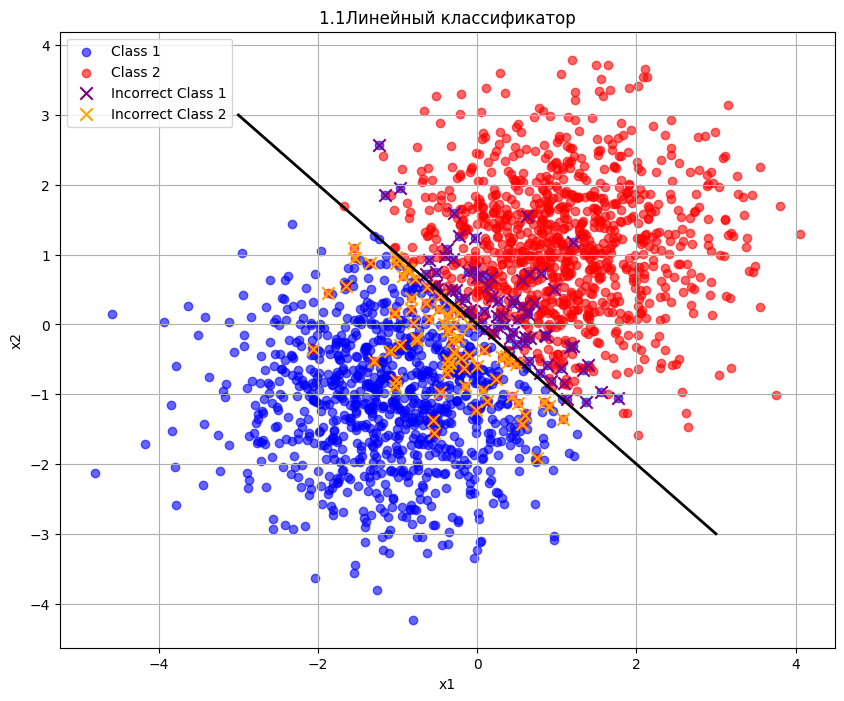

Теоретическая вероятность ошибки через интегралы: 0.07864960352514261
Эмпирическая вероятность ошибки: 0.071
95% доверительный интервал для вероятности ошибки: (0.05974436180498493, 0.08225563819501505)


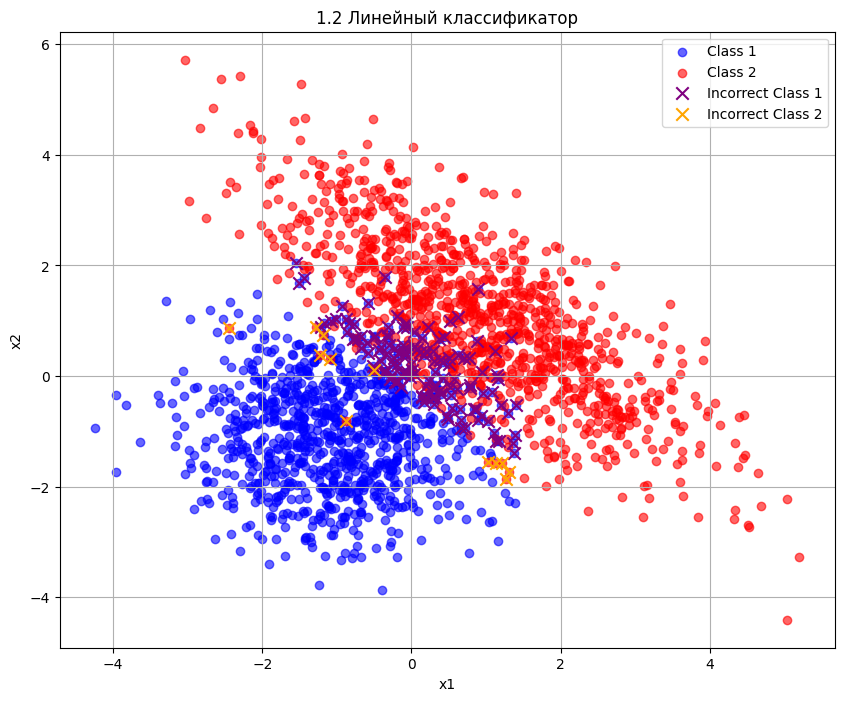

Теоретическая вероятность ошибки через интегралы: 0.04877447296534576
Эмпирическая вероятность ошибки: 0.0745
95% доверительный интервал для вероятности ошибки: (0.06299201092018777, 0.08600798907981222)


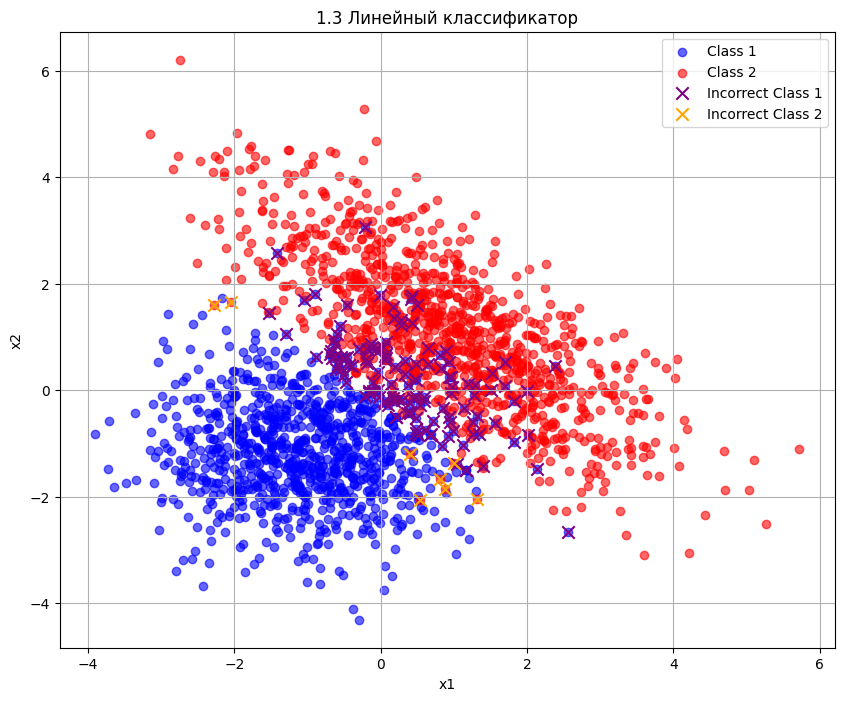

Теоретическая вероятность ошибки через интегралы: 0.04877447296534576
Эмпирическая вероятность ошибки: 0.071
95% доверительный интервал для вероятности ошибки: (0.05974436180498493, 0.08225563819501505)

Случай априорной неопределенности.


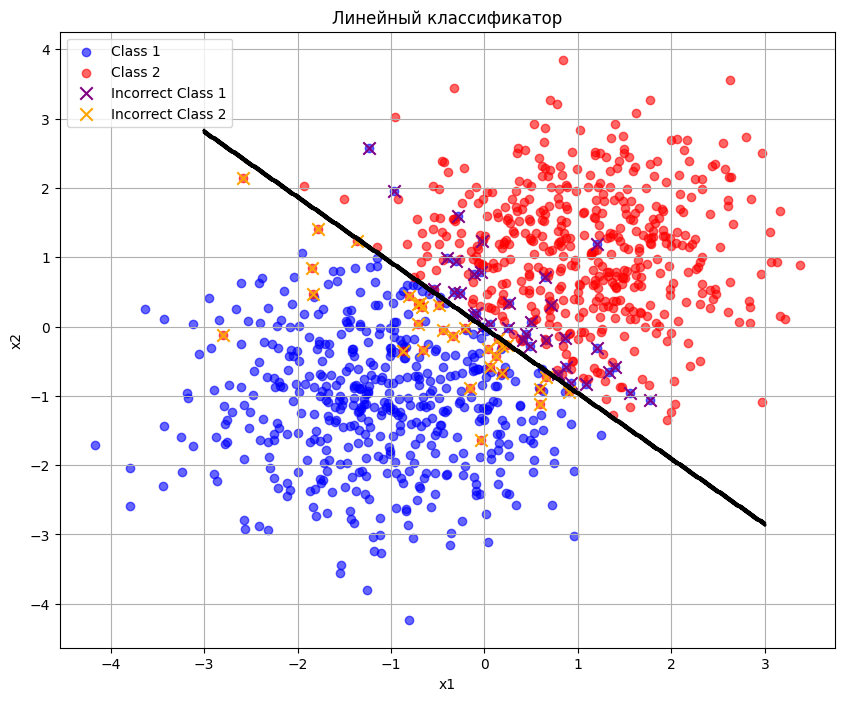

Теоретическая вероятность ошибки: 0.07064043436182954
Эмпирическая вероятность ошибки: 0.065
95% доверительный интервал для вероятности ошибки: (0.04972044961958352, 0.08027955038041648)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import inv

# Случай полной априорной информации.
print("Случай полной априорной информации.")
np.random.seed(123)

mu1 = np.array([-1, -1])
mu2 = np.array([1, 1])

Sigma1 = np.array([[1, 0], [0, 1]])
Sigma2 = np.array([[1, 0], [0, 1]])

# Функция для нахождения оптимального y_star
def find_y_star():
    y_values = np.arange(0, 1.05, 0.05)
    results = np.zeros(len(y_values))

    for i, y in enumerate(y_values):
        combined_sigma = y * Sigma1 + (1 - y) * Sigma2
        z = np.dot(inv(combined_sigma), (mu2 - mu1))
        quadratic_term = (y**2 * Sigma1 + (1 - y)**2 * Sigma2)
        results[i] = np.dot(z.T, np.dot(quadratic_term, z))
    
    y_star = y_values[np.argmin(np.abs(results))]
    return y_star

# Функция для расчета beta_star
def calculate_beta_star(y_star):
    combined_sigma = y_star * Sigma1 + (1 - y_star) * Sigma2
    b_star = np.dot(inv(combined_sigma), (mu2 - mu1))

    beta_star = -(((np.sqrt(np.dot(b_star.T, np.dot(Sigma2, b_star))) * np.dot(b_star.T, mu1)) + 
                    (np.sqrt(np.dot(b_star.T, np.dot(Sigma1, b_star))) * np.dot(b_star.T, mu2))) / 
                   (np.sqrt(np.dot(b_star.T, np.dot(Sigma1, b_star))) + 
                    np.sqrt(np.dot(b_star.T, np.dot(Sigma2, b_star)))))

    return b_star, beta_star

# Функция для классификации
def l(x, b_star, beta_star):
    return np.dot(b_star.T, x) - beta_star

def d(x, b_star, beta_star):
    return 3/2 + 1/2 * np.sign(l(x, b_star, beta_star))

# Функция для расчета вероятности ошибки
def theoretical_error_probability(b_star, mu1, mu2, Sigma1, Sigma2):
    numerator = np.abs(np.dot(b_star.T, (mu2 - mu1)))
    term1 = np.sqrt(np.dot(b_star.T, np.dot(Sigma1, b_star)))
    term2 = np.sqrt(np.dot(b_star.T, np.dot(Sigma2, b_star)))
    denominator = term1 + term2
    delta_value = numerator / denominator
    phi_delta = norm.cdf(delta_value)
    return 1 - phi_delta

# Генерация случайных точек для классов
def generate_data(n_points, mu1, mu2, Sigma1, Sigma2):
    class1_points = np.random.multivariate_normal(mu1, Sigma1, n_points)
    class2_points = np.random.multivariate_normal(mu2, Sigma2, n_points)
    return class1_points, class2_points

# Параметры
n_points = 1000
alpha = 0.05
z_value = norm.ppf(1 - alpha / 2)

# Номер 1
y_star = find_y_star()
b_star, beta_star = calculate_beta_star(y_star)
class1_points, class2_points = generate_data(n_points, mu1, mu2, Sigma1, Sigma2)

# Генерация сетки для границы
x1_seq = np.linspace(-3, 3, 100)
x2_seq = np.linspace(-3, 3, 100)
x1_grid, x2_grid = np.meshgrid(x1_seq, x2_seq)
grid = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

grid_d = np.apply_along_axis(lambda row: l(row, b_star, beta_star), 1, grid)
boundary = grid[np.abs(grid_d) < 0.05]

# Прогнозы для точек классов
class1_pred = np.array([d(class1_points[i, :], b_star, beta_star) == 1 for i in range(n_points)])
class2_pred = np.array([d(class2_points[i, :], b_star, beta_star) == 2 for i in range(n_points)])

# Неправильно классифицированные точки
incorrect_class1 = class1_points[~class1_pred, :]
incorrect_class2 = class2_points[~class2_pred, :]

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(class1_points[:, 0], class1_points[:, 1], color="blue", alpha=0.6, label="Class 1")
plt.scatter(class2_points[:, 0], class2_points[:, 1], color="red", alpha=0.6, label="Class 2")
plt.plot(boundary[:, 0], boundary[:, 1], color="black", lw=2)
plt.scatter(incorrect_class1[:, 0], incorrect_class1[:, 1], color="purple", s=80, marker="x", label="Incorrect Class 1")
plt.scatter(incorrect_class2[:, 0], incorrect_class2[:, 1], color="orange", s=80, marker="x", label="Incorrect Class 2")
plt.title("1.1Линейный классификатор")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

# Теоретическая вероятность ошибки
theoretical_prob = theoretical_error_probability(b_star, mu1, mu2, Sigma1, Sigma2)

# Эмпирическая вероятность ошибки
error_rate = (len(incorrect_class1) + len(incorrect_class2)) / (n_points * 2)

# Доверительный интервал для вероятности ошибки
se = np.sqrt((error_rate * (1 - error_rate)) / (n_points * 2))
ci_lower = error_rate - z_value * se
ci_upper = error_rate + z_value * se

print(f"Теоретическая вероятность ошибки через интегралы: {theoretical_prob}")
print(f"Эмпирическая вероятность ошибки: {error_rate}")
print(f"95% доверительный интервал для вероятности ошибки: ({ci_lower}, {ci_upper})")

# Номер 2
Sigma2 = np.array([[2, -1.5], [-1.5, 2]])

y_star = find_y_star()
b_star, beta_star = calculate_beta_star(y_star)
class1_points, class2_points = generate_data(n_points, mu1, mu2, Sigma1, Sigma2)

# Генерация сетки для границы
grid_d = np.apply_along_axis(lambda row: l(row, b_star, beta_star), 1, grid)
boundary = grid[np.abs(grid_d) < 0.05]

# Прогнозы для точек классов
class1_pred = np.array([d(class1_points[i, :], b_star, beta_star) == 1 for i in range(n_points)])
class2_pred = np.array([d(class2_points[i, :], b_star, beta_star) == 2 for i in range(n_points)])

# Неправильно классифицированные точки
incorrect_class1 = class1_points[~class1_pred, :]
incorrect_class2 = class2_points[~class2_pred, :]

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(class1_points[:, 0], class1_points[:, 1], color="blue", alpha=0.6, label="Class 1")
plt.scatter(class2_points[:, 0], class2_points[:, 1], color="red", alpha=0.6, label="Class 2")
plt.plot(boundary[:, 0], boundary[:, 1], color="black", lw=2)
plt.scatter(incorrect_class1[:, 0], incorrect_class1[:, 1], color="purple", s=80, marker="x", label="Incorrect Class 1")
plt.scatter(incorrect_class2[:, 0], incorrect_class2[:, 1], color="orange", s=80, marker="x", label="Incorrect Class 2")
plt.title("1.2 Линейный классификатор")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

# Теоретическая вероятность ошибки
theoretical_prob = theoretical_error_probability(b_star, mu1, mu2, Sigma1, Sigma2)

# Эмпирическая вероятность ошибки
error_rate = (len(incorrect_class1) + len(incorrect_class2)) / (n_points * 2)

# Доверительный интервал для вероятности ошибки
se = np.sqrt((error_rate * (1 - error_rate)) / (n_points * 2))
ci_lower = error_rate - z_value * se
ci_upper = error_rate + z_value * se

print(f"Теоретическая вероятность ошибки через интегралы: {theoretical_prob}")
print(f"Эмпирическая вероятность ошибки: {error_rate}")
print(f"95% доверительный интервал для вероятности ошибки: ({ci_lower}, {ci_upper})")

# Номер 3
Sigma2 = np.array([[2, -1.5], [-1.5, 2]])

y_star = find_y_star()
b_star, beta_star = calculate_beta_star(y_star)
class1_points, class2_points = generate_data(n_points, mu1, mu2, Sigma1, Sigma2)

# Генерация сетки для границы
grid_d = np.apply_along_axis(lambda row: l(row, b_star, beta_star), 1, grid)
boundary = grid[np.abs(grid_d) < 0.05]

# Прогнозы для точек классов
class1_pred = np.array([d(class1_points[i, :], b_star, beta_star) == 1 for i in range(n_points)])
class2_pred = np.array([d(class2_points[i, :], b_star, beta_star) == 2 for i in range(n_points)])

# Неправильно классифицированные точки
incorrect_class1 = class1_points[~class1_pred, :]
incorrect_class2 = class2_points[~class2_pred, :]

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(class1_points[:, 0], class1_points[:, 1], color="blue", alpha=0.6, label="Class 1")
plt.scatter(class2_points[:, 0], class2_points[:, 1], color="red", alpha=0.6, label="Class 2")
plt.plot(boundary[:, 0], boundary[:, 1], color="black", lw=2)
plt.scatter(incorrect_class1[:, 0], incorrect_class1[:, 1], color="purple", s=80, marker="x", label="Incorrect Class 1")
plt.scatter(incorrect_class2[:, 0], incorrect_class2[:, 1], color="orange", s=80, marker="x", label="Incorrect Class 2")
plt.title("1.3 Линейный классификатор")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

# Теоретическая вероятность ошибки
theoretical_prob = theoretical_error_probability(b_star, mu1, mu2, Sigma1, Sigma2)

# Эмпирическая вероятность ошибки
error_rate = (len(incorrect_class1) + len(incorrect_class2)) / (n_points * 2)

# Доверительный интервал для вероятности ошибки
se = np.sqrt((error_rate * (1 - error_rate)) / (n_points * 2))
ci_lower = error_rate - z_value * se
ci_upper = error_rate + z_value * se

print(f"Теоретическая вероятность ошибки через интегралы: {theoretical_prob}")
print(f"Эмпирическая вероятность ошибки: {error_rate}")
print(f"95% доверительный интервал для вероятности ошибки: ({ci_lower}, {ci_upper})\n")

# Случай априорной неопределенности.
print("Случай априорной неопределенности.")

np.random.seed(123)

# Заданные параметры
n_points = 500
mu1 = np.array([-1, -1])
mu2 = np.array([1, 1])

# Генерация случайных точек для двух классов
class1_points = np.random.multivariate_normal(mu1, np.array([[1, 0], [0, 1]]), n_points)
class2_points = np.random.multivariate_normal(mu2, np.array([[1, 0], [0, 1]]), n_points)

# Объединяем данные
training_data = np.vstack([class1_points, class2_points])
labels = np.concatenate([np.ones(n_points), np.ones(n_points) * 2])

# Оценка параметров для классов
mu_est1 = np.mean(class1_points, axis=0)
mu_est2 = np.mean(class2_points, axis=0)
Sigma_est1 = np.cov(class1_points.T)
Sigma_est2 = np.cov(class2_points.T)

# Функция для нахождения y_star
def find_y_star():
    y_values = np.arange(0, 1.05, 0.05)
    results = np.zeros(len(y_values))

    for i, y in enumerate(y_values):
        combined_sigma = y * Sigma_est1 + (1 - y) * Sigma_est2
        z = np.dot(inv(combined_sigma), (mu_est2 - mu_est1))
        quadratic_term = (y**2 * Sigma_est1 + (1 - y)**2 * Sigma_est2)
        results[i] = np.dot(z.T, np.dot(quadratic_term, z))
    
    y_star = y_values[np.argmin(np.abs(results))]
    return y_star

y_star = find_y_star()

# Вычисление параметров классификатора
combined_sigma = y_star * Sigma_est1 + (1 - y_star) * Sigma_est2
b_star = np.dot(inv(combined_sigma), (mu_est2 - mu_est1))

beta_star = -(((np.sqrt(np.dot(b_star.T, np.dot(Sigma_est2, b_star))) * np.dot(b_star.T, mu_est1)) + 
                (np.sqrt(np.dot(b_star.T, np.dot(Sigma_est1, b_star))) * np.dot(b_star.T, mu_est2))) / 
               (np.sqrt(np.dot(b_star.T, np.dot(Sigma_est1, b_star))) + 
                np.sqrt(np.dot(b_star.T, np.dot(Sigma_est2, b_star)))))

# Функции для классификации
def l(x):
    return np.dot(b_star.T, x) - beta_star

def d(x):
    return 3/2 + 1/2 * np.sign(l(x))

# Генерация сетки для границы классификации
x1_seq = np.linspace(-3, 3, 500)
x2_seq = np.linspace(-3, 3, 500)
x1_grid, x2_grid = np.meshgrid(x1_seq, x2_seq)
grid = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

grid_class = np.apply_along_axis(lambda row: l(row), 1, grid)

boundary = grid[np.abs(grid_class) < 0.05]

# Прогнозы для классов
class1_pred = np.array([d(class1_points[i, :]) == 1 for i in range(n_points)])
class2_pred = np.array([d(class2_points[i, :]) == 2 for i in range(n_points)])

# Неправильно классифицированные точки
incorrect_class1 = class1_points[~class1_pred, :]
incorrect_class2 = class2_points[~class2_pred, :]

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(class1_points[:, 0], class1_points[:, 1], color="blue", alpha=0.6, label="Class 1")
plt.scatter(class2_points[:, 0], class2_points[:, 1], color="red", alpha=0.6, label="Class 2")
plt.plot(boundary[:, 0], boundary[:, 1], color="black", lw=2)
plt.scatter(incorrect_class1[:, 0], incorrect_class1[:, 1], color="purple", s=80, marker="x", label="Incorrect Class 1")
plt.scatter(incorrect_class2[:, 0], incorrect_class2[:, 1], color="orange", s=80, marker="x", label="Incorrect Class 2")
plt.title("Линейный классификатор")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

# Функция для расчета вероятности ошибки
def delta():
    numerator = np.abs(np.dot(b_star.T, (mu_est2 - mu_est1)))
    term1 = np.sqrt(np.dot(b_star.T, np.dot(Sigma_est1, b_star)))
    term2 = np.sqrt(np.dot(b_star.T, np.dot(Sigma_est2, b_star)))
    denominator = term1 + term2
    return numerator / denominator

# Теоретическая вероятность ошибки
def theoretical_error_probability():
    delta_value = delta()
    phi_delta = norm.cdf(delta_value)
    p = 1 - phi_delta
    return p

theoretical_prob = theoretical_error_probability()

# Эмпирическая вероятность ошибки
error_rate = (len(incorrect_class1) + len(incorrect_class2)) / (n_points * 2)

# Доверительный интервал для вероятности ошибки
alpha = 0.05
z_value = norm.ppf(1 - alpha / 2)
se = np.sqrt((error_rate * (1 - error_rate)) / (n_points * 2))
ci_lower = error_rate - z_value * se
ci_upper = error_rate + z_value * se

# Вывод результатов
print(f"Теоретическая вероятность ошибки: {theoretical_prob}")
print(f"Эмпирическая вероятность ошибки: {error_rate}")
print(f"95% доверительный интервал для вероятности ошибки: ({ci_lower}, {ci_upper})")
